# Analysis of genes related to batch-effects:

load modules:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

for pretty code formatting:

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_hlca_core = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
dir_results = "../../results/batch_related_genes/"

load data:

In [4]:
adata = sc.read_h5ad(path_hlca_core)

Perform differential expression analysis on datasets, once per (coarse) cell type.

In [5]:
deg_dfs_sign = dict()  # significance
deg_dfs_es = dict()  # effect size

In [17]:
min_n_cells = 10
min_n_samples = 3

In [40]:
for ct in adata.obs.manual_ann_grouped.unique():
    print(f"Working on celltype {ct}")
    subadata = adata[adata.obs.manual_ann_grouped == ct, :].copy()
    # throw out datasets that have fewer than min_n_cells of the ct
    dataset_cell_sample_count = (
        subadata.obs.groupby("dataset")
        .agg({"dataset": "count", "sample": "nunique"})
        .rename(columns={"dataset": "ncells", "sample": "nsamples"})
    )
    ds_to_keep = dataset_cell_sample_count.loc[
        [
            suffcells and suffsamples
            for suffcells, suffsamples in zip(
                dataset_cell_sample_count.ncells >= min_n_cells,
                dataset_cell_sample_count.nsamples >= min_n_samples,
            )
        ],
        :,
    ].index.tolist()
    subadata = subadata[subadata.obs.dataset.isin(ds_to_keep), :].copy()
    sc.tl.rank_genes_groups(subadata, groupby="dataset", method="wilcoxon")
    deg_df_sign = pd.DataFrame(
        index=adata.var.index, columns=sorted(adata.obs.dataset.unique())
    )
    deg_df_es = pd.DataFrame(
        index=adata.var.index, columns=sorted(adata.obs.dataset.unique())
    )
    for dataset in ds_to_keep:
        # extract gene sets per dataset:
        genes_sign_df = sc.get.rank_genes_groups_df(subadata, group=dataset)
        genes_sign_df.index = genes_sign_df.names
        # take only significant ones
        genes_sign = genes_sign_df.loc[genes_sign_df.pvals_adj < 0.05].names
        # set significant ones to true in overview dataframe
        deg_df_sign[dataset] = False
        deg_df_sign.loc[genes_sign, dataset] = True
        deg_df_es[dataset] = np.nan
        deg_df_es.loc[genes_sign, dataset] = genes_sign_df.loc[
            genes_sign, "logfoldchanges"
        ]
    deg_dfs_sign[ct] = deg_df_sign
    deg_dfs_es[ct] = deg_df_es

Working on celltype Alveolar macrophages
Working on celltype Innate lymphoid cell NK
Working on celltype AT2
Working on celltype Basal
Working on celltype EC venous
Working on celltype T cell lineage
Working on celltype EC arterial
Working on celltype Peribronchial fibroblasts
Working on celltype AT1
Working on celltype Multiciliated
Working on celltype Plasma cells
Working on celltype Secretory
Working on celltype Smooth muscle
Working on celltype Monocytes
Working on celltype Monocyte-derived Mph
Working on celltype SMG serous
Working on celltype EC capillary
Working on celltype Adventitial fibroblasts
Working on celltype Lymphatic EC
Working on celltype Transitional Club-AT2 cells
Working on celltype Alveolar fibroblasts
Working on celltype Neuroendocrine
Working on celltype DC2
Working on celltype DC1
Working on celltype Myofibroblasts
Working on celltype B cell
Working on celltype Mast cells
Working on celltype Interstitial Mph perivascular
Working on celltype SMG mucous
Working o

In [41]:
import pickle

In [43]:
with open("../../../batch_deg_dfs_sign.pickle", "wb") as handle:
    pickle.dump(deg_dfs_sign, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../../../batch_deg_dfs_es.pickle", "wb") as handle:
    pickle.dump(deg_dfs_es, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

For each cell type, count the number (or fraction?) of datasets for which the gene is significantly differentially expressed.<br> 
Consider subselecting to only over-expressed or under-expressed genes!! So that a single super-ambient RNA does not dominate the results.

Create empty dataframe counting, per gene, in how many datasets the gene is differentially expressed:

In [69]:
n_datasets_diff_per_ct = pd.DataFrame(
    index=adata.var.index, columns=sorted(adata.obs.manual_ann_grouped.unique())
)

fraction instead of absolute count (so that we can disregard datasets that had too few cells/samples):

In [70]:
frac_dataset_diff_per_ct = n_datasets_diff_per_ct.copy()

or only differentially upregulated (and not down), absolute count:

In [71]:
n_datasets_up_per_ct = n_datasets_diff_per_ct.copy()

or fraction:

In [72]:
frac_datasets_up_per_ct = n_datasets_diff_per_ct.copy()

now fill in dataframes:

In [121]:
for ct in n_datasets_diff_per_ct.columns:
    deg_df = deg_dfs_sign[ct]
    es_df = deg_dfs_es[ct]
    # for each gene, count number of datasets with "True" (i.e. significantly diff. expr)
    n_datasets_diff_per_ct.loc[deg_df.index, ct] = deg_df.sum(axis=1)
    # for each gene, count number of datasets with "True" and a pos. eff. size
    n_datasets_up_per_ct.loc[es_df.index, ct] = (es_df > 0).sum(
        axis=1
    )  # the df only contains effect sizes for significant genes
    # check for how many datasets we had data
    deg_df_notnull = ~pd.isnull(deg_df)
    # now calculate fraction among datasets for which we could do dea
    frac_dataset_diff_per_ct.loc[deg_df.index, ct] = deg_df.sum(
        axis=1
    ) / deg_df_notnull.sum(axis=1)
    frac_datasets_up_per_ct.loc[deg_df.index, ct] = (es_df > 0).sum(
        axis=1
    ) / deg_df_notnull.sum(axis=1)

Check which genes are consistently associated with batch effects:

Differentially expressed...:

In [122]:
n_dataset_diff_gene_mean = n_datasets_diff_per_ct.mean(axis=1)

In [123]:
n_dataset_diff_gene_mean.sort_values(ascending=False).head(40)  # top in absolute number

RPL13A        7.102564
RPL27A        6.974359
RPS17         6.769231
RPL7          6.692308
RPL31         6.666667
RPS6          6.615385
TMSB4X        6.589744
RPL41         6.564103
RPL23A        6.538462
RPS20         6.538462
RPS27         6.435897
RPL3          6.410256
RPL21         6.410256
RPS18         6.384615
RPL37A        6.358974
RPS29         6.307692
MT-ND4        6.256410
RPLP2         6.205128
RPL26         6.179487
MT-ND2        6.128205
RPS2          6.076923
RPL38         6.051282
RPS9          6.051282
RPS25         6.051282
RPL27         6.025641
FTL           6.025641
RPL35         6.025641
RPL13         6.025641
RPL23         6.000000
RPL18A        5.948718
RPL15         5.948718
RPL34         5.948718
MT-ND4L       5.923077
RPS14         5.897436
AC090498.1    5.871795
MALAT1        5.846154
RPL9          5.820513
RPL36A        5.794872
RPL10         5.794872
RPS10         5.794872
dtype: float64

In [124]:
frac_dataset_diff_gene_mean = frac_dataset_diff_per_ct.mean(axis=1)

In [125]:
frac_dataset_diff_gene_mean.sort_values(ascending=False).head(50)  # top in fraction

RPL13A        0.865863
RPL27A        0.833118
RPS17         0.817062
RPL7          0.812179
RPL31         0.807835
RPL41         0.807305
RPS6          0.802920
RPL23A        0.789041
RPL3          0.783767
RPL21         0.780581
RPS18         0.780565
RPS27         0.774987
RPS29         0.773197
TMSB4X        0.770113
MT-ND4        0.768952
RPS20         0.765769
RPL37A        0.758535
RPS2          0.752146
RPLP2         0.751240
RPL26         0.747099
MT-ND4L       0.742133
RPS9          0.735487
RPL38         0.732486
MT-ND2        0.732149
RPL27         0.730933
RPL35         0.727613
RPL15         0.726311
RPL23         0.722789
FTL           0.715037
AC090498.1    0.713401
RPL34         0.711760
RPL18A        0.710152
RPL13         0.703337
RPL36A        0.703128
HSPA1A        0.701972
MALAT1        0.698962
B2M           0.693899
RPS25         0.693465
RPS11         0.693116
RPL32         0.692171
HSP90AA1      0.687052
JUN           0.685811
RPS4X         0.685121
RPS10      

...or only upregulated:

In [126]:
n_dataset_up_gene_mean = n_datasets_up_per_ct.mean(axis=1)

In [127]:
n_dataset_up_gene_mean.sort_values(ascending=False).head(50)

RPL13A    4.820513
RPL27A    4.666667
RPS17     4.487179
RPS20     4.461538
TMSB4X    4.384615
RPS6      4.384615
RPL41     4.358974
RPL31     4.333333
RPL7      4.307692
RPS18     4.153846
RPS2      4.102564
RPL23A    4.076923
RPL23     4.076923
RPS9      4.051282
RPL21     4.051282
RPL3      4.051282
MT-ND4    3.923077
RPS11     3.897436
RPL37A    3.871795
RPS27     3.871795
RPS29     3.871795
RPL13     3.794872
RPLP2     3.769231
RPL27     3.743590
MT-ND2    3.743590
RPL18A    3.717949
RPL35     3.717949
RPL9      3.717949
MALAT1    3.692308
RPL26     3.666667
FTL       3.666667
RPL15     3.641026
RPL38     3.615385
RPS16     3.564103
RPS14     3.564103
UBA52     3.538462
RPS25     3.487179
RPL10A    3.487179
RPS4X     3.435897
RPS19     3.410256
FTH1      3.358974
RPL10     3.333333
TPT1      3.307692
RPL34     3.307692
RPS3      3.282051
SAT1      3.282051
RPS15     3.256410
OAZ1      3.230769
MT-ND1    3.230769
ATP5O     3.230769
dtype: float64

In [128]:
frac_dataset_up_gene_mean = frac_datasets_up_per_ct.mean(axis=1)

In [129]:
frac_dataset_up_gene_mean.sort_values(ascending=False).head(50)

RPL13A    0.568862
RPL27A    0.542243
RPS17     0.523002
RPL41     0.519452
RPS6      0.513044
RPL31     0.511628
RPS20     0.509949
RPL7      0.507741
TMSB4X    0.498652
RPS18     0.487655
RPS2      0.484694
RPL3      0.482902
RPL23A    0.479443
RPL21     0.477783
RPS9      0.471260
RPL23     0.469564
MT-ND4    0.469469
RPS27     0.461587
RPS29     0.457482
RPS11     0.452621
RPL37A    0.448153
MT-ND2    0.445019
RPL27     0.443446
RPLP2     0.442844
RPL35     0.437144
RPL26     0.435820
RPL15     0.434998
RPL18A    0.430927
RPL13     0.428792
MALAT1    0.427771
FTL       0.426204
RPL38     0.425983
RPL9      0.420311
UBA52     0.412706
RPS14     0.403983
RPS4X     0.400820
RPS25     0.397541
RPS16     0.396869
RPL10A    0.396719
RPL34     0.395041
RPS19     0.390012
FTH1      0.389940
RPL32     0.383357
RPL4      0.383039
RPS3      0.378015
RPL10     0.377954
RPS15A    0.376325
SAT1      0.375785
RPS23     0.375237
RPL36A    0.374635
dtype: float64

## Store result:

In [130]:
df_to_store = pd.DataFrame(
    data=frac_dataset_up_gene_mean,
    columns=[
        "fraction of datasets in which significantly upregulated (mean across cell types)"
    ],
).sort_values(
    by="fraction of datasets in which significantly upregulated (mean across cell types)",
    ascending=False,
)

In [131]:
df_to_store.to_csv(os.path.join(dir_results, "batch_gene_list.csv"))

## Analyze top 50:

In [132]:
top_50 = df_to_store.head(50).index.tolist()

In [133]:
n_ribosomal = np.sum(
    [gene.startswith("RPL") or gene.startswith("RPS") for gene in top_50]
)

In [134]:
n_mitochondrial = np.sum([gene.startswith("MT-") for gene in top_50])

In [135]:
non_ribo_non_mito = [gene for gene in top_50 if gene[:3] not in ["RPL", "RPS", "MT-"]]

In [136]:
print(f"n ribosomal genes: {n_ribosomal}\nn_mitochondrial: {n_mitochondrial}")

n ribosomal genes: 42
n_mitochondrial: 2


In [137]:
non_ribo_non_mito

['TMSB4X', 'MALAT1', 'FTL', 'UBA52', 'FTH1', 'SAT1']

basically correspond to most highly expressed genes:

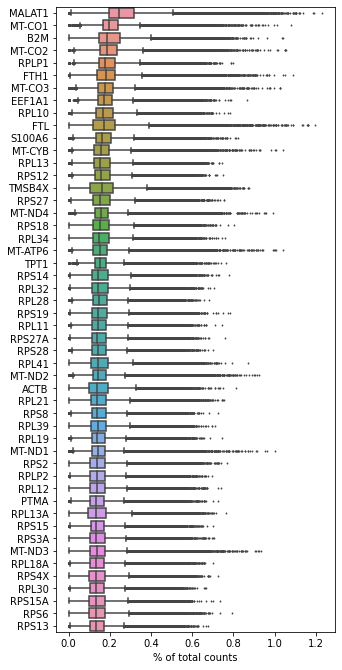

In [138]:
sc.pl.highest_expr_genes(adata, n_top=50)